# MultiAgent System

There are two patterns: 

- Network
- Supervisor   : Hierarichal Pattern

In [241]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [227]:
from langchain_openai import ChatOpenAI
#llm=ChatOpenAI(model = "gpt-4o-mini")
llm = ChatOpenAI()

In [228]:
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent

## Creating a dummy multi agent

It is for **network/collaborative** multi agent 

In [229]:
from langchain_core.tools import tool

In [230]:
def add_number(state):
    result = state["num1"] + state["num2"]
    print(f"Result of the addition: {result}")
    return Command(goto="multiply", update={"sum":result})

In [231]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return 

In [232]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help. Addition is a mathematical sum between 2 or more
    numbers"""
    return

In [233]:
from typing_extensions import Literal
from langgraph.graph import MessagesState, StateGraph, START, END

In [234]:
# Agent I
def additional_expert(state: MessagesState) -> Command[Literal["multiplication_expert","__end__"]]:
    print("---- ADDTION EXPERT-----")
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help" 
        "with multiplication."
        "Always do your portion for calculation before the handoff."
    )

    messages = [
        {"role": "system", "content": system_prompt}
    ] + state["messages"]

    llm_with_tool = llm.bind_tools([transfer_to_multiplication_expert]) # Additional expert only need access of Multiplication tool

    ai_message = llm_with_tool.invoke(messages) # If the additional expert can perform the operation
                                                # On its own, it will perform the operation
                                                # Else, it will make tool call.
    

    if len(ai_message.tool_calls) > 0: 
        print("---- ai_message.tool_calls > 0 -----")
        # If the ai_message asked for tool_calls, that means we need to call the tool.
        tool_call_id = ai_message.tool_calls[-1]["id"]

        # [OPTIONAL] We can also create a metadata for tool message
        tool_message = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id
        }

        # Return the Command function (Langgraph internal method) to connect current Agent to 
        # other tool
        return Command(
            goto="multiplication_expert",  # Name of the next tool to call
            update={"messages" : [ai_message, tool_message]} # Update to the Agent Message 
        )

    # If no tool call is required, Agent can answer from its knowledge.
    print("---- ai_message.tool_calls < 0 -----")
    return {"messages": [ai_message]}

In [235]:
# Agent II
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    print("---- MULTIPLICATION AGENT ----")
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [236]:
workflow = StateGraph(MessagesState)

# name of the nodes must be same as the values set in the Literals during function definition
workflow.add_node("additional_expert", additional_expert)
workflow.add_node("multiplication_expert", multiplication_expert)

In [237]:
workflow.add_edge(START, "additional_expert")

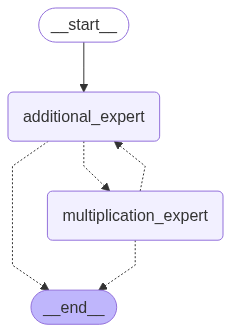

In [238]:
app = workflow.compile()
app

In [239]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

---- ADDTION EXPERT-----
---- ai_message.tool_calls > 0 -----
---- MULTIPLICATION AGENT ----
---- ADDTION EXPERT-----
---- ai_message.tool_calls < 0 -----


{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='82c051b8-8fa1-4ff4-8308-4b2dd80b32dd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_McLqYlrJSa2pBGFw50eeqKHT', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 86, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BlC0RzP2naQyaCq9ed5skQslZG28B', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--21a81708-9ef2-4151-9d8b-7cf2d7b936e1-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}

# With realtime tool

Tools:

    - DuckDuckGoSearchRun : For Google search
    - PythonREPL : For Python code execution
    - TavilySearchResults: For Tavily Online search


    - Common system message for all the Agents
    - get_next_node function to identify the next node to call

In [208]:
from langchain_community.tools import DuckDuckGoSearchRun

In [210]:
search_tool=DuckDuckGoSearchRun() 

👉 **<u>Web Search Tool</u>**

In [244]:
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
search_tool = TavilySearchResults(tavily_api_key=TAVILY_API_KEY, max_results=1)

In [245]:
search_tool.invoke("What is the current score between India and England's match?")

[{'title': 'IND vs ENG Live Score, 1st Test Match Day 3 - Times of India',
  'url': 'https://timesofindia.indiatimes.com/sports/cricket/ind-vs-eng-live-score-today-cricket-match-india-national-cricket-team-vs-england-cricket-team-1st-test-match-day-3-scorecard/liveblog/122003050.cms',
  'content': 'Hello and welcome to our live coverage of the five-match Test series between India and England.   \n  \nThe first Test at Leeds is nicely poised. While Bumrah continued to create chances, India, unfortunately, didn’t hold on to them, but England riding on a spunky century from Ollie Pope has made a remarkable comeback after restricting India to 471. England in reply are 309 for 3, still trailing by 269 runs.',
  'score': 0.7197191}]

👉 **<u>Code Execution Tool</u>**

In [250]:
from langchain_experimental.utilities import PythonREPL
from typing import Annotated

In [215]:
repl=PythonREPL()

In [246]:
code = """
x = 5
y = x * 2
print(y)
"""

In [249]:
# Test
print(repl.run(code))

10



**Create a Langchain tool from PythonREPL**

In [261]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."]
    ):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [254]:
python_repl_tool

StructuredTool(name='python_repl_tool', description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'langchain_core.utils.pydantic.python_repl_tool'>, func=<function python_repl_tool at 0x000002BFA459AB60>)

In [262]:
# Test
from IPython.display import display, Markdown
from rich import print

display(Markdown(python_repl_tool.invoke(code)))

Successfully executed:
```python

x = 5
y = x * 2
print(y)

```
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.

**Create Prompt**

In [264]:
# As multiple agents will be used, create a commond system prompt
# We can append Agent specific instructions

def make_system_prompt(instruction:str)->str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [265]:
from langchain_core.messages import BaseMessage, HumanMessage

In [280]:
def get_next_node(last_message :BaseMessage, goto :str):
    """Function to pass the control to next node"""
    if 'FINAL ANSWER' in last_message.content:
        # If any agent has decided to stop when the work is done
        return END
    return goto

In [273]:
#agent1
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    """Create a research agent using in-build create_react_agent template
    that creates an agent graph that calls tools in a loop until a stopping 
    condition is met."""
    
    research_agent = create_react_agent(
        llm,  
        tools = [search_tool],
        prompt = make_system_prompt(
            "You can only do research. You are working with a chart generator colleague."
            )
    )

    # Agent receives the state messages as input
    result = research_agent.invoke(state)

    goto = get_next_node(result["messages"][-1], "chart_generator")

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content,
        name="researcher")

    # Return the commands to update the graph's state and send messages to nodes
    return Command(update={"messages": result["messages"]}, goto=goto)

In [275]:
#agent2
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    """Function to create a chart"""
    chart_agent=create_react_agent(
        llm,
        tools=[python_repl_tool], # uses python repl tool to execute the python code
        prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
            )
        )
    
    result=chart_agent.invoke(state)

    # If the result contains "FINAL ANSWER" keyword then end the loop, else go to the 'researcher' agent.
    goto=get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    return Command(update={"messages": result["messages"]},goto=goto)

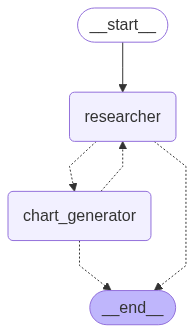

In [278]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()
app

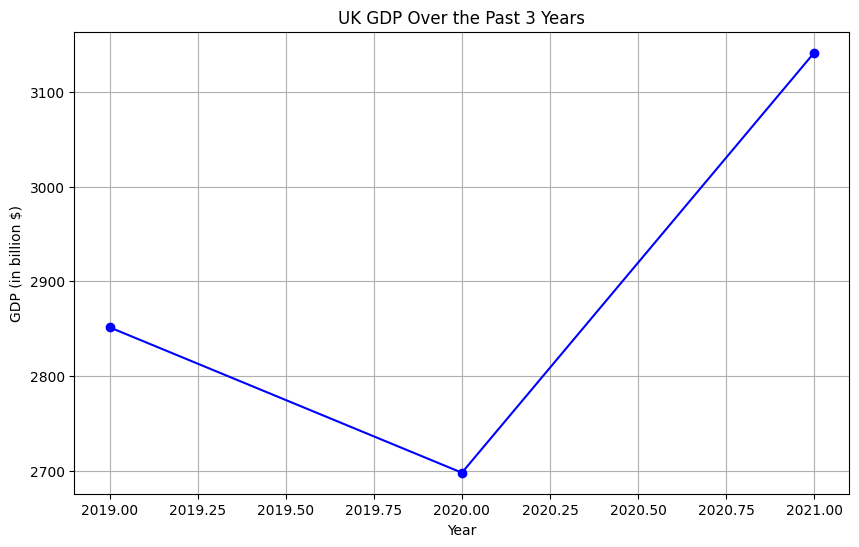

{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='a04ab9ea-56b5-4bbf-be9f-5fe6e4a9692e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kKGT0FvFoECMdIOsA1ZswC7m', 'function': {'arguments': '{"query":"UK GDP by year 2019-2021"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 209, 'total_tokens': 236, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BlHkeGmoTyStFNCszCyPxjU96EjhE', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abe2f362-d6ac-45a5-a1d

In [283]:
# Test
app.invoke(
    {
        "messages": [
                    ("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")
                    ]
    })
